In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
import torchvision
from torch.utils import data
from torchvision import transforms
from time import time
import multiprocessing as mp

In [2]:
class BasicBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 48

        self.conv1 = nn.Conv2d(3, 48, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(48)
        self.layer1 = self._make_layer(block, 48, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 96, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 192, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 384, num_blocks[3], stride=2)
        self.linear = nn.Linear(384, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

def project1_model():
    return ResNet(BasicBlock, [1, 2, 4, 1])

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [3]:
transform_train = torchvision.transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=256, shuffle=True, num_workers=1)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=1000, shuffle=False, num_workers=1)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [4]:
net = project1_model()

num = count_parameters(net)
print(num)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

net.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
#CosineAnnealingLR(optimizer, T_max=20) 
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

train_loss_list = []
train_acc_list = []
#train_dur_list = []
test_loss_list = []
test_acc_list = []
#test_dur_list = []

4919674


In [15]:
def train(epoch):
    print('\nEpoch: %d' % epoch)
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    batch_index = 0
    t0 = time()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        # loss = nll(outputs, targets)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        batch_index = batch_idx
        # train_loss += loss.item()
        train_loss = loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        #print(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                     #% (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        #print("\n")
    train_loss_list.append(train_loss/(batch_index+1))
    train_acc_list.append(100.*correct/total)
    print(' Train: Loss: %.6f | Acc: %.3f%% | Dur: %.2fS' 
          % (train_loss/(batch_index+1), 100.*correct/total, time() - t0))

def test(epoch):
#     global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    batch_index = 0
    t0 = time()
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            # loss = nll(outputs, targets)
            batch_index = batch_idx
            # test_loss += loss.item()
            test_loss = loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            #print(batch_idx, len(testloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                         #% (test_loss/(batch_idx+1), 100.*correct/total, correct, total))
            #print("\n")
    test_loss_list.append(test_loss/(batch_index+1))
    test_acc_list.append(100.*correct/total)
    print(' Test:  Loss: %.6f | Acc: %.3f%% | Dur: %.2fS' 
          % (test_loss/(batch_index+1), 100.*correct/total, time() - t0))

    # Save checkpoint.
#     acc = 100.*correct/total
#     if acc > best_acc:
#         print('Saving..')
#         state = {
#             'net': net.state_dict(),
#             'acc': acc,
#             'epoch': epoch,
#             'train_history': (train_loss_list, train_acc_list, test_loss_list, test_acc_list)
#         }
#         if not os.path.isdir('checkpoint'):
#             os.mkdir('checkpoint')
#         torch.save(state, './checkpoint/ckpt_rmsprop.pth')
#         best_acc = acc


def plot_model(train_loss, train_acc, test_loss, test_acc):
    length = len(train_acc)
    plt.subplot(2, 2, 1)
    plt.plot(range(length), train_acc)
    plt.title('Train accuracy vs. epoches')
    plt.ylabel('Train accuracy')
    plt.xlabel('epoch')
    plt.subplot(2, 2, 2)
    plt.plot(range(length), train_loss)
    plt.title('Train loss vs. epoches')
    plt.ylabel('Train loss')
    plt.xlabel('epoch')
    plt.subplot(2, 2, 3)
    plt.plot(range(length), test_acc)
    plt.title('Test accuracy vs. epoches')
    plt.ylabel('Test accuracy')
    plt.xlabel('epoch')
    plt.subplot(2, 2, 4)
    plt.plot(range(length), test_loss)
    plt.title('Test loss vs. epoches')
    plt.ylabel('Test loss')
    plt.xlabel('epoch')
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.6, 
                    hspace=0.8)

In [6]:
for epoch in range(150):
    train(epoch)
    test(epoch)
    scheduler.step()


Epoch: 0
 Train: Loss: 0.006547 | Acc: 44.392% | Dur: 15.57S
 Test:  Loss: 0.147039 | Acc: 51.390% | Dur: 2.51S

Epoch: 1
 Train: Loss: 0.005745 | Acc: 63.706% | Dur: 12.27S
 Test:  Loss: 0.096508 | Acc: 66.750% | Dur: 2.51S

Epoch: 2
 Train: Loss: 0.003311 | Acc: 72.314% | Dur: 12.21S
 Test:  Loss: 0.085222 | Acc: 70.250% | Dur: 2.54S

Epoch: 3
 Train: Loss: 0.002849 | Acc: 76.890% | Dur: 12.34S
 Test:  Loss: 0.069871 | Acc: 75.280% | Dur: 2.55S

Epoch: 4
 Train: Loss: 0.002409 | Acc: 80.220% | Dur: 12.04S
 Test:  Loss: 0.067921 | Acc: 76.900% | Dur: 2.50S

Epoch: 5
 Train: Loss: 0.002452 | Acc: 82.562% | Dur: 12.24S
 Test:  Loss: 0.057878 | Acc: 79.570% | Dur: 2.54S

Epoch: 6
 Train: Loss: 0.001640 | Acc: 84.216% | Dur: 12.22S
 Test:  Loss: 0.056883 | Acc: 81.000% | Dur: 2.64S

Epoch: 7
 Train: Loss: 0.002619 | Acc: 85.364% | Dur: 12.24S
 Test:  Loss: 0.044514 | Acc: 83.070% | Dur: 2.52S

Epoch: 8
 Train: Loss: 0.002114 | Acc: 86.660% | Dur: 12.21S
 Test:  Loss: 0.055944 | Acc: 80.3

 Train: Loss: 0.000068 | Acc: 99.872% | Dur: 12.14S
 Test:  Loss: 0.042884 | Acc: 91.060% | Dur: 2.51S

Epoch: 73
 Train: Loss: 0.000202 | Acc: 99.852% | Dur: 12.22S
 Test:  Loss: 0.042504 | Acc: 91.190% | Dur: 2.54S

Epoch: 74
 Train: Loss: 0.000175 | Acc: 99.874% | Dur: 12.04S
 Test:  Loss: 0.042480 | Acc: 91.330% | Dur: 2.58S

Epoch: 75
 Train: Loss: 0.000044 | Acc: 99.878% | Dur: 12.28S
 Test:  Loss: 0.043042 | Acc: 91.020% | Dur: 2.55S

Epoch: 76
 Train: Loss: 0.000070 | Acc: 99.886% | Dur: 12.04S
 Test:  Loss: 0.043389 | Acc: 91.110% | Dur: 2.59S

Epoch: 77
 Train: Loss: 0.000089 | Acc: 99.854% | Dur: 12.36S
 Test:  Loss: 0.043307 | Acc: 91.150% | Dur: 2.52S

Epoch: 78
 Train: Loss: 0.000047 | Acc: 99.874% | Dur: 12.36S
 Test:  Loss: 0.043510 | Acc: 91.160% | Dur: 2.59S

Epoch: 79
 Train: Loss: 0.000040 | Acc: 99.884% | Dur: 12.23S
 Test:  Loss: 0.042915 | Acc: 91.100% | Dur: 2.62S

Epoch: 80
 Train: Loss: 0.000067 | Acc: 99.894% | Dur: 12.31S
 Test:  Loss: 0.042533 | Acc: 91.180

 Train: Loss: 0.000045 | Acc: 99.916% | Dur: 12.63S
 Test:  Loss: 0.043618 | Acc: 91.140% | Dur: 2.59S

Epoch: 145
 Train: Loss: 0.000041 | Acc: 99.926% | Dur: 12.60S
 Test:  Loss: 0.043992 | Acc: 91.170% | Dur: 2.63S

Epoch: 146
 Train: Loss: 0.000194 | Acc: 99.908% | Dur: 12.64S
 Test:  Loss: 0.043661 | Acc: 91.030% | Dur: 2.58S

Epoch: 147
 Train: Loss: 0.000048 | Acc: 99.922% | Dur: 12.64S
 Test:  Loss: 0.043707 | Acc: 91.180% | Dur: 2.62S

Epoch: 148
 Train: Loss: 0.000053 | Acc: 99.912% | Dur: 12.65S
 Test:  Loss: 0.044049 | Acc: 91.170% | Dur: 2.57S

Epoch: 149
 Train: Loss: 0.000041 | Acc: 99.908% | Dur: 12.62S
 Test:  Loss: 0.043749 | Acc: 91.100% | Dur: 2.60S


In [7]:
print(train_acc_list)
print(train_loss_list)

[44.392, 63.706, 72.314, 76.89, 80.22, 82.562, 84.216, 85.364, 86.66, 87.642, 88.664, 89.494, 90.34, 91.024, 91.482, 92.164, 92.612, 93.162, 93.75, 94.106, 94.502, 95.114, 95.132, 95.738, 96.114, 96.376, 96.624, 96.806, 97.16, 97.438, 97.634, 97.798, 97.92, 98.186, 98.438, 98.528, 98.652, 98.898, 98.934, 99.066, 99.088, 99.174, 99.306, 99.35, 99.392, 99.46, 99.536, 99.542, 99.514, 99.63, 99.656, 99.644, 99.632, 99.722, 99.758, 99.726, 99.72, 99.772, 99.746, 99.784, 99.748, 99.81, 99.822, 99.822, 99.856, 99.828, 99.862, 99.832, 99.866, 99.854, 99.836, 99.876, 99.872, 99.852, 99.874, 99.878, 99.886, 99.854, 99.874, 99.884, 99.894, 99.9, 99.888, 99.906, 99.896, 99.908, 99.898, 99.918, 99.908, 99.884, 99.926, 99.898, 99.884, 99.906, 99.9, 99.91, 99.914, 99.902, 99.916, 99.918, 99.918, 99.894, 99.888, 99.908, 99.884, 99.908, 99.908, 99.91, 99.918, 99.912, 99.946, 99.916, 99.916, 99.91, 99.934, 99.908, 99.926, 99.906, 99.918, 99.926, 99.912, 99.914, 99.924, 99.94, 99.914, 99.924, 99.932, 99.

In [8]:
print(test_acc_list)
print(test_loss_list)

[51.39, 66.75, 70.25, 75.28, 76.9, 79.57, 81.0, 83.07, 80.3, 84.7, 84.88, 84.22, 83.85, 84.94, 85.25, 86.49, 85.83, 85.37, 85.97, 88.41, 88.38, 88.46, 89.03, 87.26, 89.11, 88.29, 88.66, 89.01, 89.12, 89.44, 88.84, 89.85, 89.76, 90.09, 90.69, 89.58, 89.93, 90.27, 89.98, 89.98, 90.38, 90.19, 90.65, 90.31, 90.65, 90.53, 90.52, 90.76, 90.81, 90.7, 90.75, 90.87, 90.83, 91.03, 90.93, 90.98, 90.8, 90.85, 90.98, 90.98, 90.89, 90.88, 90.99, 91.06, 91.03, 90.99, 91.03, 91.09, 90.94, 91.01, 91.02, 91.17, 91.06, 91.19, 91.33, 91.02, 91.11, 91.15, 91.16, 91.1, 91.18, 91.08, 91.08, 91.21, 91.12, 90.89, 90.94, 91.07, 91.09, 90.95, 91.12, 91.04, 91.01, 91.14, 91.0, 91.06, 91.12, 91.09, 91.01, 91.04, 91.09, 91.03, 91.06, 91.1, 91.1, 91.12, 91.1, 91.05, 91.19, 91.19, 91.1, 91.18, 91.23, 91.11, 91.18, 91.19, 91.06, 91.08, 91.1, 91.12, 91.03, 91.09, 91.11, 91.08, 91.16, 91.12, 91.19, 91.05, 91.16, 91.16, 91.2, 91.13, 91.09, 91.1, 91.08, 91.1, 91.13, 91.13, 91.13, 91.12, 91.06, 91.11, 91.21, 91.14, 91.14, 

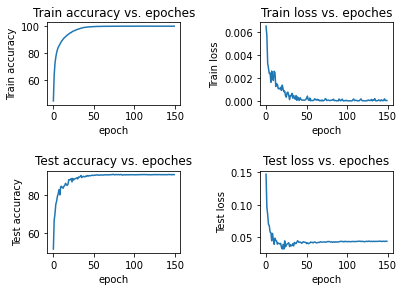

In [16]:
plot_model(train_loss_list,train_acc_list,test_loss_list,test_acc_list)

In [10]:
model_path = './project1_model.pt'
torch.save(net.state_dict(), model_path)